# Assignment 4: AutoML - Hyperparameter Optimization

This notebook implements two hyperparameter optimization strategies for a neural network classifier:
1. **Genetic Algorithm** - Evolutionary approach with roulette selection, one-point crossover, and age-based replacement
2. **Bayesian Optimization** - Probabilistic model-based optimization

**Hyperparameters being tuned:**
- Mini-batch size B ∈ [16, 1024]
- Activation function ∈ {ReLU, Sigmoid, Tanh}

Github Usernmae: vapanpa

Github Repo Link: https://github.com/vapanpa/mlds490-reinforcementlearning/tree/main/HW4

In [ ]:
# Core dependencies
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
import random
import copy

# Reproducibility settings
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Compute device selection
COMPUTE_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {COMPUTE_DEVICE}")


Using device: cuda


## Data Preparation

Load the Federated EMNIST dataset, filter for digit classes (0-9), normalize, and create train/validation/test splits.


In [ ]:
def prepare_dataset():
    """
    Loads and preprocesses the EMNIST data:
    - Extracts images/labels from federated format
    - Filters to keep only digit classes
    - Normalizes pixel values
    - Creates 80/20 train/validation split
    """
    def unpack_federated_data(file_path):
        """Extract all client data from federated format into single arrays."""
        raw = np.load(file_path, allow_pickle=True)
        if raw.ndim == 0:
            raw = raw.item()
        
        images_list, labels_list = [], []
        data_iterator = raw.values() if isinstance(raw, dict) else raw
        
        for client_data in data_iterator:
            if isinstance(client_data, dict) and 'images' in client_data:
                images_list.append(client_data['images'])
                labels_list.append(client_data['labels'])
        
        return np.vstack(images_list), np.hstack(labels_list)
    
    # Load raw federated data
    X_train_raw, y_train_raw = unpack_federated_data('data/train_data.npy')
    X_test_raw, y_test_raw = unpack_federated_data('data/test_data.npy')
    
    print(f"Raw training samples: {len(y_train_raw)}")
    
    # Keep only digit classes (labels 0-9)
    digit_mask_train = y_train_raw < 10
    digit_mask_test = y_test_raw < 10
    
    X_train_digits = X_train_raw[digit_mask_train]
    y_train_digits = y_train_raw[digit_mask_train]
    X_test_digits = X_test_raw[digit_mask_test]
    y_test_digits = y_test_raw[digit_mask_test]
    
    print(f"Digit-only training samples: {len(y_train_digits)}")
    
    # Remap labels to contiguous range [0, num_classes-1]
    unique_classes = np.unique(y_train_digits)
    label_mapping = {old_label: new_idx for new_idx, old_label in enumerate(sorted(unique_classes))}
    
    y_train_mapped = np.array([label_mapping[lbl] for lbl in y_train_digits])
    y_test_mapped = np.array([label_mapping[lbl] for lbl in y_test_digits])
    
    # Normalize pixel intensities to [0, 1]
    X_train_norm = X_train_digits.astype(np.float32)
    X_test_norm = X_test_digits.astype(np.float32)
    if X_train_norm.max() > 1.0:
        X_train_norm /= 255.0
        X_test_norm /= 255.0
    
    # Flatten images if multi-dimensional
    if X_train_norm.ndim > 2:
        X_train_norm = X_train_norm.reshape(X_train_norm.shape[0], -1)
        X_test_norm = X_test_norm.reshape(X_test_norm.shape[0], -1)
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_norm)
    y_train_tensor = torch.tensor(y_train_mapped, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test_norm)
    y_test_tensor = torch.tensor(y_test_mapped, dtype=torch.long)
    
    # Create full training dataset
    full_train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    # 80/20 stratified-ish split using shuffled indices
    n_total = len(full_train_dataset)
    n_train = int(0.8 * n_total)
    
    shuffled_indices = np.random.permutation(n_total)
    train_indices = shuffled_indices[:n_train]
    val_indices = shuffled_indices[n_train:]
    
    train_subset = Subset(full_train_dataset, train_indices)
    val_subset = Subset(full_train_dataset, val_indices)
    
    feature_dim = X_train_norm.shape[1]
    n_classes = len(unique_classes)
    
    print(f"Feature dimension: {feature_dim}")
    print(f"Number of classes: {n_classes}")
    print(f"Training samples: {len(train_subset)}, Validation samples: {len(val_subset)}, Test samples: {len(test_dataset)}")
    
    return train_subset, val_subset, test_dataset, feature_dim, n_classes

# Execute data preparation
train_data, val_data, test_data, INPUT_DIM, NUM_CLASSES = prepare_dataset()


Raw training samples: 31825
Digit-only training samples: 9517
Feature dimension: 784
Number of classes: 10
Training samples: 7613, Validation samples: 1904, Test samples: 1049


## Neural Network Architecture

A two-layer feedforward network with a configurable hidden layer activation function.


In [ ]:
class FeedForwardClassifier(nn.Module):
    """
    Simple two-layer neural network for classification.
    Architecture: Input -> Hidden (with activation) -> Output
    """
    ACTIVATION_MAP = {
        'relu': nn.ReLU,
        'sigmoid': nn.Sigmoid,
        'tanh': nn.Tanh
    }
    
    def __init__(self, in_features, hidden_units, out_features, activation_type='relu'):
        super().__init__()
        self.hidden_layer = nn.Linear(in_features, hidden_units)
        self.output_layer = nn.Linear(hidden_units, out_features)
        
        # Get activation function from mapping, default to ReLU
        activation_class = self.ACTIVATION_MAP.get(activation_type.lower(), nn.ReLU)
        self.activation_fn = activation_class()
    
    def forward(self, x):
        hidden_out = self.activation_fn(self.hidden_layer(x))
        return self.output_layer(hidden_out)


def compute_validation_f1(batch_sz, activation_type, training_set, validation_set, 
                          in_dim, n_classes, num_epochs=10):
    """
    Train a model with given hyperparameters and return validation F1 score.
    Uses SGD optimizer with mini-batch training.
    """
    # Clamp batch size to valid range
    batch_sz = int(np.clip(batch_sz, 16, 1024))
    
    train_loader = DataLoader(training_set, batch_size=batch_sz, shuffle=True)
    val_loader = DataLoader(validation_set, batch_size=batch_sz, shuffle=False)
    
    # Initialize model, optimizer, and loss function
    model = FeedForwardClassifier(in_dim, 256, n_classes, activation_type).to(COMPUTE_DEVICE)
    sgd_optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    loss_fn = nn.CrossEntropyLoss()
    
    # Training loop
    for _ in range(num_epochs):
        model.train()
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(COMPUTE_DEVICE)
            batch_y = batch_y.to(COMPUTE_DEVICE)
            
            sgd_optimizer.zero_grad()
            predictions = model(batch_x)
            loss = loss_fn(predictions, batch_y)
            loss.backward()
            sgd_optimizer.step()
    
    # Validation evaluation
    model.eval()
    all_predictions = []
    all_ground_truth = []
    
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(COMPUTE_DEVICE)
            logits = model(batch_x)
            predicted_classes = torch.argmax(logits, dim=1)
            all_predictions.extend(predicted_classes.cpu().numpy())
            all_ground_truth.extend(batch_y.numpy())
    
    return f1_score(all_ground_truth, all_predictions, average='macro')


## Part 1: Genetic Algorithm

Implementation featuring:
- **Roulette wheel selection**: Parents chosen proportionally to their fitness
- **One-point crossover**: Genetic material split at a random point between parents
- **Age-based replacement**: Individuals removed after surviving a maximum number of generations
- **Mutation**: Random perturbations to maintain diversity


In [ ]:
class EvolutionaryHyperparamSearch:
    """
    Genetic Algorithm for hyperparameter optimization with:
    - Roulette wheel parent selection
    - One-point crossover
    - Age-based population management
    """
    
    AVAILABLE_ACTIVATIONS = ['relu', 'sigmoid', 'tanh']
    
    def __init__(self, population_count, generation_limit, max_lifespan,
                 train_set, val_set, input_dim, num_classes, mutation_rate=0.15):
        self.population_count = population_count
        self.generation_limit = generation_limit
        self.max_lifespan = max_lifespan  # Maximum generations an individual can survive
        self.mutation_rate = mutation_rate
        
        self.train_set = train_set
        self.val_set = val_set
        self.input_dim = input_dim
        self.num_classes = num_classes
        
        self.current_population = []
        self.generation_best_scores = []
        self.generation_avg_scores = []
    
    def _create_individual(self):
        """Generate a random individual with age 0."""
        return {
            'batch_size': random.randint(16, 1024),
            'activation': random.choice(self.AVAILABLE_ACTIVATIONS),
            'fitness': 0.0,
            'age': 0
        }
    
    def _evaluate_fitness(self, individual):
        """Compute fitness (F1 score) for an individual."""
        score = compute_validation_f1(
            individual['batch_size'],
            individual['activation'],
            self.train_set,
            self.val_set,
            self.input_dim,
            self.num_classes
        )
        individual['fitness'] = score
        return score
    
    def _roulette_wheel_select(self):
        """
        Select a parent using roulette wheel (fitness-proportionate) selection.
        Higher fitness = higher probability of selection.
        """
        fitness_values = [ind['fitness'] for ind in self.current_population]
        total_fitness = sum(fitness_values)
        
        # Handle edge case where all fitness is zero
        if total_fitness <= 0:
            return random.choice(self.current_population)
        
        # Spin the wheel
        spin = random.uniform(0, total_fitness)
        cumulative = 0
        
        for individual in self.current_population:
            cumulative += individual['fitness']
            if cumulative >= spin:
                return individual
        
        return self.current_population[-1]
    
    def _one_point_crossover(self, parent_a, parent_b):
        """
        Perform one-point crossover between two parents.
        Genes: [batch_size, activation]
        Crossover point determines which genes come from which parent.
        """
        # For 2 genes, crossover point can be 0 or 1
        # Point 0: child gets all from parent_a
        # Point 1: child gets first gene from parent_a, second from parent_b
        crossover_point = random.randint(0, 1)
        
        if crossover_point == 0:
            # All genes from parent_a
            child_batch = parent_a['batch_size']
            child_activation = parent_a['activation']
        else:
            # First gene from parent_a, second from parent_b
            child_batch = parent_a['batch_size']
            child_activation = parent_b['activation']
        
        return {
            'batch_size': child_batch,
            'activation': child_activation,
            'fitness': 0.0,
            'age': 0  # New offspring starts at age 0
        }
    
    def _apply_mutation(self, individual):
        """Apply random mutations based on mutation rate."""
        if random.random() < self.mutation_rate:
            individual['batch_size'] = random.randint(16, 1024)
        
        if random.random() < self.mutation_rate:
            individual['activation'] = random.choice(self.AVAILABLE_ACTIVATIONS)
        
        return individual
    
    def _age_based_culling(self):
        """Remove individuals that have exceeded maximum lifespan."""
        self.current_population = [
            ind for ind in self.current_population 
            if ind['age'] < self.max_lifespan
        ]
    
    def evolve(self):
        """Run the evolutionary process."""
        # Initialize population
        self.current_population = [self._create_individual() for _ in range(self.population_count)]
        
        # Evaluate initial population
        print("Evaluating initial population...")
        for ind in self.current_population:
            self._evaluate_fitness(ind)
        
        # Evolution loop
        for gen in range(self.generation_limit):
            # Age all individuals
            for ind in self.current_population:
                ind['age'] += 1
            
            # Remove individuals that are too old
            self._age_based_culling()
            
            # Sort by fitness (descending)
            self.current_population.sort(key=lambda x: x['fitness'], reverse=True)
            
            # Record statistics
            current_best = self.current_population[0]['fitness']
            current_avg = np.mean([ind['fitness'] for ind in self.current_population])
            self.generation_best_scores.append(current_best)
            self.generation_avg_scores.append(current_avg)
            
            print(f"Generation {gen + 1}/{self.generation_limit} | "
                  f"Best: {current_best:.4f} | Avg: {current_avg:.4f} | "
                  f"Pop size: {len(self.current_population)}")
            
            # Build next generation
            next_generation = []
            
            # Elitism: keep the best individual (with age preserved)
            elite = copy.deepcopy(self.current_population[0])
            next_generation.append(elite)
            
            # Generate offspring to fill population
            while len(next_generation) < self.population_count:
                # Select parents via roulette wheel
                mom = self._roulette_wheel_select()
                dad = self._roulette_wheel_select()
                
                # Create offspring via one-point crossover
                child = self._one_point_crossover(mom, dad)
                
                # Apply mutation
                child = self._apply_mutation(child)
                
                # Evaluate offspring fitness
                self._evaluate_fitness(child)
                
                next_generation.append(child)
            
            self.current_population = next_generation
        
        # Return best individual from final population
        self.current_population.sort(key=lambda x: x['fitness'], reverse=True)
        return self.current_population[0]
    
    def plot_evolution_history(self):
        """Visualize fitness progression across generations."""
        generations = range(1, len(self.generation_best_scores) + 1)
        
        plt.figure(figsize=(10, 6))
        plt.plot(generations, self.generation_avg_scores, 'b-o', label='Average Fitness', alpha=0.7)
        plt.plot(generations, self.generation_best_scores, 'r-s', label='Best Fitness', alpha=0.7)
        plt.xlabel('Generation')
        plt.ylabel('Validation F1 Score (Macro)')
        plt.title('Genetic Algorithm: Fitness Evolution')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


In [ ]:
# Run Genetic Algorithm search
ga_searcher = EvolutionaryHyperparamSearch(
    population_count=20,
    generation_limit=20,
    max_lifespan=5,  # Individuals removed after 5 generations
    train_set=train_data,
    val_set=val_data,
    input_dim=INPUT_DIM,
    num_classes=NUM_CLASSES,
    mutation_rate=0.15
)

best_ga_solution = ga_searcher.evolve()

print("\n" + "="*50)
print("GENETIC ALGORITHM RESULTS")
print("="*50)
print(f"Best Batch Size: {best_ga_solution['batch_size']}")
print(f"Best Activation: {best_ga_solution['activation']}")
print(f"Validation F1 Score: {best_ga_solution['fitness']:.4f}")


Evaluating initial population...
Generation 1/20 | Best: 0.7755 | Avg: 0.3038 | Pop size: 20
Generation 2/20 | Best: 0.7905 | Avg: 0.4863 | Pop size: 20
Generation 3/20 | Best: 0.7905 | Avg: 0.5764 | Pop size: 20
Generation 4/20 | Best: 0.7946 | Avg: 0.5829 | Pop size: 20
Generation 5/20 | Best: 0.7946 | Avg: 0.6516 | Pop size: 20
Generation 6/20 | Best: 0.8101 | Avg: 0.6409 | Pop size: 20
Generation 7/20 | Best: 0.8101 | Avg: 0.6471 | Pop size: 20
Generation 8/20 | Best: 0.8101 | Avg: 0.5678 | Pop size: 20
Generation 9/20 | Best: 0.8101 | Avg: 0.7075 | Pop size: 20
Generation 10/20 | Best: 0.7871 | Avg: 0.6713 | Pop size: 19
Generation 11/20 | Best: 0.7965 | Avg: 0.6827 | Pop size: 20
Generation 12/20 | Best: 0.7965 | Avg: 0.6112 | Pop size: 20
Generation 13/20 | Best: 0.7965 | Avg: 0.5711 | Pop size: 20
Generation 14/20 | Best: 0.7994 | Avg: 0.7392 | Pop size: 20
Generation 15/20 | Best: 0.7994 | Avg: 0.6603 | Pop size: 20
Generation 16/20 | Best: 0.8011 | Avg: 0.6476 | Pop size: 20


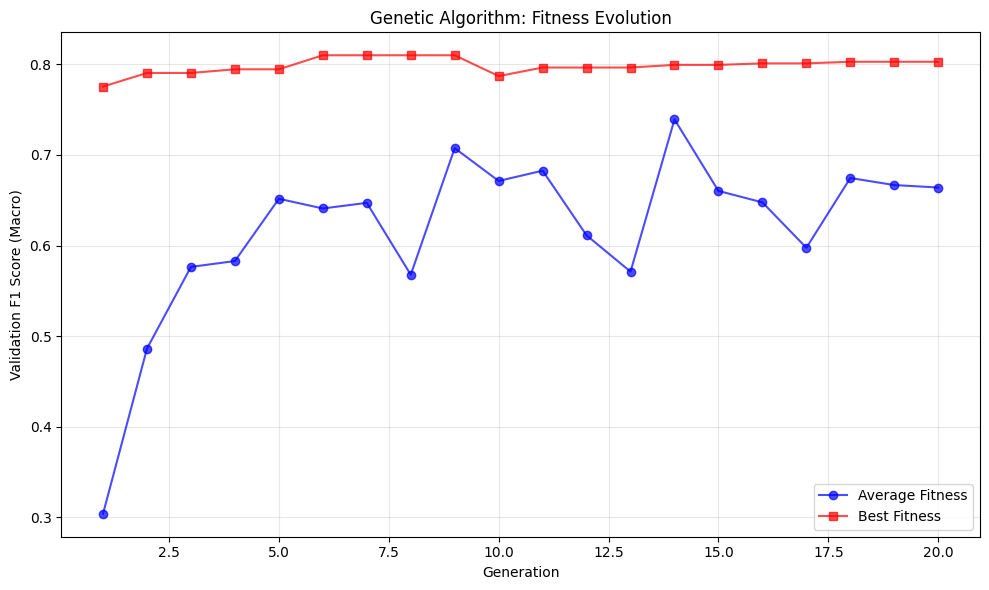

In [ ]:
# Plot GA evolution progress
ga_searcher.plot_evolution_history()


## Part 2: Bayesian Optimization

Using the `bayesian-optimization` package to find optimal hyperparameters by modeling the objective function with a Gaussian Process surrogate.


In [ ]:
def bayesian_hyperparameter_search(train_set, val_set, in_dim, n_classes,
                                    n_random_init=10, n_iterations=40):
    """
    Use Bayesian Optimization to find optimal batch size and activation function.
    Activation is encoded as a continuous value [0, 2] and discretized.
    """
    activation_options = ['relu', 'sigmoid', 'tanh']
    
    def objective_function(batch_size_continuous, activation_continuous):
        """Black-box function: returns validation F1 for given hyperparameters."""
        # Discretize activation index
        act_idx = int(np.clip(np.round(activation_continuous), 0, 2))
        chosen_activation = activation_options[act_idx]
        
        return compute_validation_f1(
            batch_size_continuous,
            chosen_activation,
            train_set,
            val_set,
            in_dim,
            n_classes
        )
    
    # Define search space bounds
    search_bounds = {
        'batch_size_continuous': (16, 1024),
        'activation_continuous': (0, 2)
    }
    
    # Initialize optimizer
    bo_optimizer = BayesianOptimization(
        f=objective_function,
        pbounds=search_bounds,
        random_state=RANDOM_SEED,
        verbose=2
    )
    
    # Run optimization
    bo_optimizer.maximize(init_points=n_random_init, n_iter=n_iterations)
    
    # Extract best parameters
    optimal_params = bo_optimizer.max['params']
    optimal_batch = int(optimal_params['batch_size_continuous'])
    optimal_act_idx = int(np.round(optimal_params['activation_continuous']))
    optimal_activation = activation_options[optimal_act_idx]
    
    return optimal_batch, optimal_activation, bo_optimizer.max['target']

# Execute Bayesian Optimization
print("Starting Bayesian Optimization...")
bo_batch_size, bo_activation, bo_best_f1 = bayesian_hyperparameter_search(
    train_data, val_data, INPUT_DIM, NUM_CLASSES
)

print("\n" + "="*50)
print("BAYESIAN OPTIMIZATION RESULTS")
print("="*50)
print(f"Best Batch Size: {bo_batch_size}")
print(f"Best Activation: {bo_activation}")
print(f"Validation F1 Score: {bo_best_f1:.4f}")


Starting Bayesian Optimization...
|   iter    |  target   | batch_... | activa... |
-------------------------------------------------
| 1         | 0.3534117 | 393.53643 | 1.9014286 |
| 2         | 0.0212206 | 753.84989 | 1.1973169 |
| 3         | 0.0205466 | 173.26678 | 0.3119890 |
| 4         | 0.7420676 | 74.548281 | 1.7323522 |
| 5         | 0.0212206 | 621.92393 | 1.4161451 |
| 6         | 0.7909241 | 36.749170 | 1.9398197 |
| 7         | 0.1480694 | 855.10218 | 0.4246782 |
| 8         | 0.5015409 | 199.27956 | 0.3668090 |
| 9         | 0.0212406 | 322.67618 | 1.0495128 |
| 10        | 0.0212206 | 451.40057 | 0.5824582 |
| 11        | 0.7510345 | 54.964284 | 0.0       |
| 12        | 0.3231825 | 37.629367 | 1.4176168 |
| 13        | 0.7466610 | 36.404013 | 1.7837637 |
| 14        | 0.3077065 | 55.006723 | 1.0848428 |
| 15        | 0.1559794 | 74.464319 | 0.8440364 |
| 16        | 0.7340078 | 75.045509 | 2.0       |
| 17        | 0.7671044 | 54.166285 | 0.0       |
| 18        | 0.

## Final Model Training and Evaluation

Train models using the best hyperparameters from each method on the combined train+validation data, then evaluate on the held-out test set.


In [ ]:
def train_final_model(batch_sz, activation, train_set, val_set, test_set,
                      in_dim, n_classes, total_epochs=50, method_label=""):
    """
    Train a model on combined train+val data with selected hyperparameters.
    Track training F1 per epoch and evaluate on test set.
    """
    print(f"\n{'='*60}")
    print(f"Final Training: {method_label}")
    print(f"Hyperparameters: batch_size={batch_sz}, activation={activation}")
    print('='*60)
    
    # Combine training and validation data
    combined_dataset = torch.utils.data.ConcatDataset([train_set, val_set])
    combined_loader = DataLoader(combined_dataset, batch_size=batch_sz, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_sz, shuffle=False)
    
    # Initialize fresh model
    model = FeedForwardClassifier(in_dim, 256, n_classes, activation).to(COMPUTE_DEVICE)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    loss_function = nn.CrossEntropyLoss()
    
    epoch_f1_scores = []
    
    for epoch in range(total_epochs):
        model.train()
        epoch_predictions = []
        epoch_labels = []
        
        for batch_x, batch_y in combined_loader:
            batch_x = batch_x.to(COMPUTE_DEVICE)
            batch_y = batch_y.to(COMPUTE_DEVICE)
            
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            # Collect predictions for F1 calculation
            preds = torch.argmax(outputs, dim=1)
            epoch_predictions.extend(preds.cpu().numpy())
            epoch_labels.extend(batch_y.cpu().numpy())
        
        # Calculate training F1 for this epoch
        train_f1 = f1_score(epoch_labels, epoch_predictions, average='macro')
        epoch_f1_scores.append(train_f1)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1:3d}/{total_epochs}: Training F1 = {train_f1:.4f}")
    
    # Evaluate on test set
    model.eval()
    test_predictions = []
    test_labels = []
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(COMPUTE_DEVICE)
            outputs = model(batch_x)
            preds = torch.argmax(outputs, dim=1)
            test_predictions.extend(preds.cpu().numpy())
            test_labels.extend(batch_y.numpy())
    
    test_f1 = f1_score(test_labels, test_predictions, average='macro')
    print(f"\nFinal Test F1 Score: {test_f1:.4f}")
    
    return epoch_f1_scores, test_f1


In [ ]:
# Train final model using GA-selected hyperparameters
ga_training_history, ga_test_score = train_final_model(
    best_ga_solution['batch_size'],
    best_ga_solution['activation'],
    train_data, val_data, test_data,
    INPUT_DIM, NUM_CLASSES,
    total_epochs=50,
    method_label="Genetic Algorithm"
)



Final Training: Genetic Algorithm
Hyperparameters: batch_size=41, activation=tanh
Epoch  10/50: Training F1 = 0.8095
Epoch  20/50: Training F1 = 0.8500
Epoch  30/50: Training F1 = 0.8702
Epoch  40/50: Training F1 = 0.8813
Epoch  50/50: Training F1 = 0.8846

Final Test F1 Score: 0.8826


In [ ]:
# Train final model using BO-selected hyperparameters
bo_training_history, bo_test_score = train_final_model(
    bo_batch_size,
    bo_activation,
    train_data, val_data, test_data,
    INPUT_DIM, NUM_CLASSES,
    total_epochs=50,
    method_label="Bayesian Optimization"
)



Final Training: Bayesian Optimization
Hyperparameters: batch_size=25, activation=tanh
Epoch  10/50: Training F1 = 0.8255
Epoch  20/50: Training F1 = 0.8625
Epoch  30/50: Training F1 = 0.8798
Epoch  40/50: Training F1 = 0.8876
Epoch  50/50: Training F1 = 0.8940

Final Test F1 Score: 0.9008


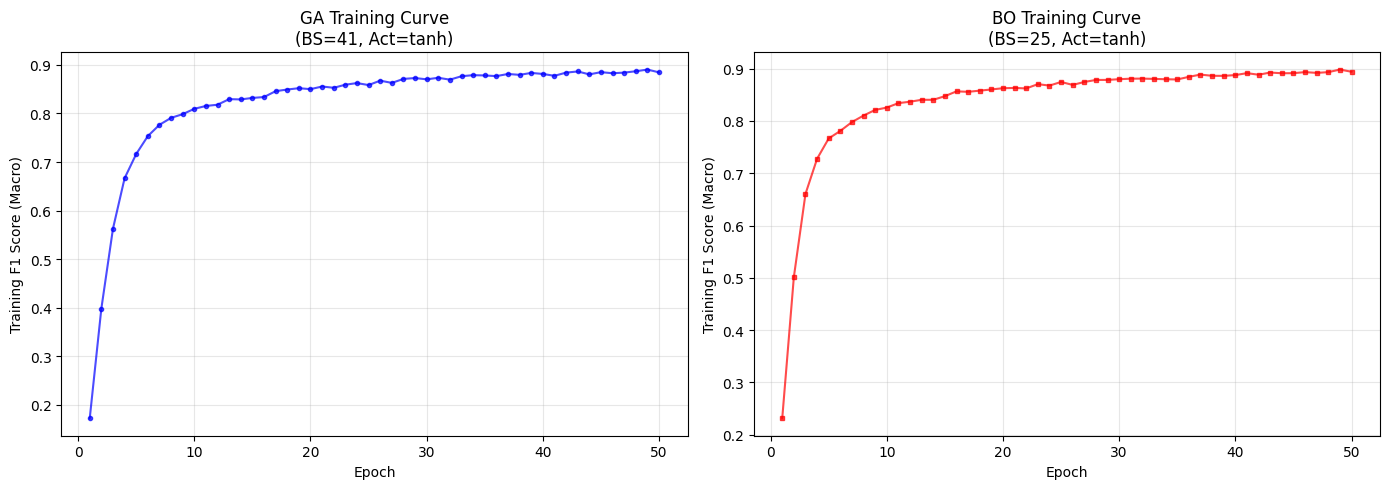

In [ ]:
# Plot training curves for both methods
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, 51)

# GA Training Curve
axes[0].plot(epochs_range, ga_training_history, 'b-o', markersize=3, alpha=0.7)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training F1 Score (Macro)')
axes[0].set_title(f'GA Training Curve\n(BS={best_ga_solution["batch_size"]}, Act={best_ga_solution["activation"]})')
axes[0].grid(True, alpha=0.3)

# BO Training Curve
axes[1].plot(epochs_range, bo_training_history, 'r-s', markersize=3, alpha=0.7)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Training F1 Score (Macro)')
axes[1].set_title(f'BO Training Curve\n(BS={bo_batch_size}, Act={bo_activation})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Results Summary and Comparison


In [ ]:
# Final results comparison
print("="*70)
print("FINAL RESULTS COMPARISON")
print("="*70)
print(f"\n{'Method':<25} {'Batch Size':<15} {'Activation':<12} {'Test F1':<10}")
print("-"*70)
print(f"{'Genetic Algorithm':<25} {best_ga_solution['batch_size']:<15} {best_ga_solution['activation']:<12} {ga_test_score:.4f}")
print(f"{'Bayesian Optimization':<25} {bo_batch_size:<15} {bo_activation:<12} {bo_test_score:.4f}")
print("="*70)


FINAL RESULTS COMPARISON

Method                    Batch Size      Activation   Test F1   
----------------------------------------------------------------------
Genetic Algorithm         41              tanh         0.8826
Bayesian Optimization     25              tanh         0.9008


## Discussion: Genetic Algorithm vs Bayesian Optimization

### Genetic Algorithm

**Advantages:**
- Explores diverse regions of the search space through population-based search
- Can escape local optima through mutation and crossover operators
- Naturally parallelizable (fitness evaluations can run concurrently)
- Does not require gradient information or assumptions about the objective function shape

**Disadvantages:**
- Computationally expensive due to large number of fitness evaluations
- Hyperparameter sensitive (population size, mutation rate, crossover type)
- May converge slowly compared to model-based approaches
- No principled way to balance exploration vs exploitation

### Bayesian Optimization

**Advantages:**
- Sample-efficient: builds a probabilistic model to guide the search
- Principled exploration-exploitation tradeoff via acquisition function
- Works well with small evaluation budgets
- Provides uncertainty estimates about the objective function

**Disadvantages:**
- Struggles with high-dimensional search spaces
- Overhead of fitting the Gaussian Process surrogate model
- Assumes smoothness of the objective function
- Handling categorical variables (like activation function) requires encoding tricks

### Comparison

Both methods are effective for hyperparameter optimization, but they excel in different scenarios. Genetic Algorithms are better suited for highly non-convex or discontinuous search spaces with many local optima, while Bayesian Optimization is preferred when evaluations are expensive and the search space is relatively smooth and low-dimensional.
